In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List, Any, Optional
from langchain_core.messages import HumanMessage
import json
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()
llm_key = os.getenv('llm_key')

In [3]:
class GraphState(TypedDict):
    user_request: str
    workflow_analysis: Dict[str, Any]  # AI-generated workflow understanding
    approval_chain: List[Dict[str, Any]]  # Dynamic approval hierarchy
    questions: Dict[str, Any]
    answers: Dict[str, Any]
    validation: Dict[str, Any]
    workflow: Dict[str, Any]
    form_schema: Dict[str, Any]
    excel_schema: Dict[str, Any]
    custom_rules: List[Dict[str, Any]]  # User-specific business rules
    sanity_check: Dict[str, Any]  # Validation results from sanity checker
    sanity_issues: List[str]  # Issues found during sanity check
    regeneration_count: int  # Track regeneration attempts
    iteration_count: int
    refinement_needed: bool
    conversation_history: List[str]  # Track clarifications

In [5]:
model=ChatOpenAI(model="openai/gpt-oss-20b:free",
                        api_key=llm_key,
                        base_url="https://openrouter.ai/api/v1")

In [6]:
def regenerate_workflow_with_fixes(state: GraphState):
    """
    Regenerate workflow components based on sanity check issues
    """
    
    issues = state.get("sanity_issues", [])
    regeneration_count = state.get("regeneration_count", 0)
    
    print("\n" + "="*80)
    print(f"🔧 REGENERATING WORKFLOW (Attempt {regeneration_count + 1})")
    print("="*80)
    
    print("\n📋 Addressing the following issues:\n")
    for idx, issue in enumerate(issues, 1):
        print(f"   {idx}. {issue}")
    
    # Create a detailed prompt for AI to fix the issues
    prompt = f"""
    You are fixing a workflow generation that failed sanity checks.

    Original User Request:
    {state['user_request']}

    Issues Found:
    {chr(10).join(f"- {issue}" for issue in issues)}

    Current Workflow Analysis:
    {json.dumps(state.get('workflow_analysis', {}), indent=2)}

    Current Approval Chain:
    {json.dumps(state.get('approval_chain', []), indent=2)}

    Your task: Generate a CORRECTED workflow analysis that fixes ALL the issues above.
    Ensure:
    1. All required fields are present
    2. Approval chain logic is correct and sequential
    3. All approvers mentioned in user request are included
    4. Parallel approvals are properly configured if needed
    5. Rejection behaviors are defined
    6. All data structures are valid JSON

    Return ONLY the corrected workflow_analysis JSON.
    """
    workflow_analysis = state.get("workflow_analysis", {}).copy()
    approval_chain = state.get("approval_chain", []).copy()
    
    # Fix missing fields
    if not workflow_analysis.get("workflow_name"):
        workflow_analysis["workflow_name"] = "University Workflow"
    
    if not workflow_analysis.get("workflow_description"):
        workflow_analysis["workflow_description"] = "Automated approval workflow"
    
    # Ensure all required fields exist
    required_fields = [
        "workflow_name", "workflow_description", "stakeholders",
        "approval_chain", "data_to_collect", "notifications", "business_rules"
    ]
    
    for field in required_fields:
        if field not in workflow_analysis:
            workflow_analysis[field] = [] if field in ["stakeholders", "approval_chain", "data_to_collect", "notifications", "business_rules"] else ""
    
    # Fix approval chain levels
    if approval_chain:
        for idx, approver in enumerate(approval_chain):
            if "level" not in approver:
                approver["level"] = idx + 1
            if "approver_role" not in approver:
                approver["approver_role"] = f"Approver {idx + 1}"
            if "approver_type" not in approver:
                approver["approver_type"] = "single"
            if "rejection_behavior" not in approver:
                approver["rejection_behavior"] = "end_workflow"
            if "conditions" not in approver:
                approver["conditions"] = []
    
    print("\n✅ Applied fixes to workflow components")
    print(f"   Regeneration count: {regeneration_count + 1}")
    
    return {
        "workflow_analysis": workflow_analysis,
        "approval_chain": approval_chain,
        "regeneration_count": regeneration_count + 1
    }


In [7]:
def analyze_request(state: GraphState):
    """
    Deep AI analysis - understand EVERYTHING about the workflow from structured user input
    """
    
    prompt = f"""
You are an expert workflow architect for Microsoft Power Automate. Analyze this workflow request.

User Request:
{state['user_request']}

Previous Conversation: {state.get('conversation_history', [])}

The user has provided a structured request with:
1. Workflow Title/Purpose
2. Chain of Process (approval hierarchy)
3. Additional Requirements

CRITICAL REQUIREMENTS - ALWAYS ENFORCE:
- Microsoft Forms MUST be used to collect input from end users
- Excel MUST be used as the activity tracker for all requests, approvals, and rejections
- Microsoft Teams Approvals MUST be used for approval/rejection actions
- Outlook MUST be used for all email notifications
- Assume all Microsoft 365 credentials are configured in environment

Extract and return a comprehensive workflow analysis in VALID JSON format:

{{
  "workflow_name": "descriptive name from user input",
  "workflow_description": "what this workflow does",
  "workflow_purpose": "problem it solves",
  
  "stakeholders": [
    {{
      "role": "Student/Faculty/Staff/etc",
      "actions": ["submit request", "receive notifications"],
      "required_info": ["name", "email", "id"]
    }}
  ],
  
  "approval_chain": [
    {{
      "level": 1,
      "approver_role": "Mentor",
      "approver_type": "single|multiple",
      "source": "from_form|configured",
      "conditions": ["first in chain", "can add comments"],
      "rejection_behavior": "end_workflow|send_back|escalate|notify_director",
      "notification_rules": ["notify submitter", "notify director if rejected"]
    }},
    {{
      "level": 2,
      "approver_role": "Class Teacher",
      "approver_type": "single",
      "source": "from_form",
      "parallel_with_level": null,
      "conditions": ["must approve after mentor"],
      "rejection_behavior": "notify_director",
      "timeout_hours": 48
    }},
    {{
      "level": 3,
      "approver_role": "Director",
      "approver_type": "single",
      "source": "from_form",
      "requires_all_previous": true,
      "final_authority": true,
      "conditions": ["makes final decision", "receives all rejection notifications"],
      "rejection_behavior": "end_workflow"
    }}
  ],
  
  "approver_info_collection": [
    {{
      "role": "Mentor",
      "fields_needed": ["name", "email"],
      "collected_via": "form",
      "required": true
    }},
    {{
      "role": "Class Teacher",
      "fields_needed": ["name", "email"],
      "collected_via": "form",
      "required": true
    }}
  ],
  
  "required_documents": [
    {{
      "name": "Supporting Document",
      "format": [".pdf", ".docx"],
      "required": false,
      "max_size_mb": 10
    }}
  ],
  
  "data_to_collect": [
    {{
      "field_name": "student_name",
      "label": "Student Name",
      "type": "text",
      "required": true,
      "validation": "string"
    }},
    {{
      "field_name": "student_email",
      "label": "Student Email",
      "type": "email",
      "required": true,
      "validation": "email"
    }},
    {{
      "field_name": "mentor_name",
      "label": "Mentor Name",
      "type": "text",
      "required": true,
      "validation": "string",
      "purpose": "approver_identification"
    }},
    {{
      "field_name": "mentor_email",
      "label": "Mentor Email",
      "type": "email",
      "required": true,
      "validation": "email",
      "purpose": "approver_contact"
    }},
    {{
      "field_name": "class_teacher_name",
      "label": "Class Teacher Name",
      "type": "text",
      "required": true,
      "validation": "string",
      "purpose": "approver_identification"
    }},
    {{
      "field_name": "class_teacher_email",
      "label": "Class Teacher Email",
      "type": "email",
      "required": true,
      "validation": "email",
      "purpose": "approver_contact"
    }},
    {{
      "field_name": "director_email",
      "label": "Director Email",
      "type": "email",
      "required": true,
      "validation": "email",
      "purpose": "notification_contact"
    }},
    {{
      "field_name": "request_details",
      "label": "Request Details",
      "type": "textarea",
      "required": true,
      "validation": "minimum_50_characters"
    }}
  ],
  
  "notifications": [
    {{
      "trigger": "form_submitted",
      "recipients": ["submitter", "first_approver"],
      "platform": "Outlook",
      "template": "confirmation"
    }},
    {{
      "trigger": "approval_at_any_level",
      "recipients": ["submitter", "next_approver"],
      "platform": "Outlook",
      "template": "approval_progress"
    }},
    {{
      "trigger": "rejection_at_any_level",
      "recipients": ["submitter", "director"],
      "platform": "Outlook",
      "template": "rejection_notice",
      "special_rule": "director must be notified of all rejections"
    }},
    {{
      "trigger": "final_approval",
      "recipients": ["submitter", "all_approvers"],
      "platform": "Outlook",
      "template": "final_decision"
    }}
  ],
  
  "tracking_requirements": [
    "submission_timestamp",
    "current_status",
    "approver_names_and_emails",
    "approval_history",
    "comments_at_each_level",
    "time_spent_at_each_level",
    "rejection_notifications_sent",
    "final_decision"
  ],
  
  "business_rules": [
    "Extract all business rules from user's additional requirements",
    "Approvals must use Microsoft Teams Approvals",
    "All tracking in Excel",
    "All emails via Outlook",
    "Director receives notification on ANY rejection"
  ],
  
  "special_features": [
    "List any special requirements from user input",
    "Custom notification rules",
    "Special escalation procedures"
  ],
  
  "platform_requirements": {{
    "form_platform": "Microsoft Forms",
    "tracking_platform": "Excel Online (Business)",
    "approval_platform": "Microsoft Teams Approvals",
    "email_platform": "Office 365 Outlook",
    "storage_platform": "SharePoint"
  }}
}}

IMPORTANT PARSING RULES:
1. Parse the approval chain from the "Chain of process" line
2. Identify the sequence: "A to B to C" means A is level 1, B is level 2, C is level 3
3. Extract special notification rules from "Additional requirements"
4. If approver info needs to be collected from end user, add those fields to "data_to_collect"
5. Always use Microsoft Teams for approvals, not standalone approval actions
6. All activity tracking goes to Excel
7. All emails use Outlook

Return ONLY valid JSON. Be thorough and extract ALL implicit requirements.
"""
    
    # In production, replace with actual LLM call
    # response = model.invoke([HumanMessage(content=prompt)])
    # analysis = json.loads(response.content)
    
    # Parse the user request
    lines = state['user_request'].strip().split('\n')
    workflow_title = lines[0].strip() if len(lines) > 0 else "University Workflow"
    
    # Parse approval chain from second line
    approval_sequence = []
    if len(lines) > 1:
        chain_line = lines[1].strip().lower()
        # Parse "student to mentor to class teacher to director"
        parts = [p.strip() for p in chain_line.replace(' to ', '|').split('|')]
        approval_sequence = [p for p in parts if p and p != 'student']
    
    # Parse additional requirements
    additional_reqs = []
    if len(lines) > 2:
        additional_reqs = [line.strip() for line in lines[2:] if line.strip()]
    
    # Build approval chain
    approval_chain = []
    for idx, role in enumerate(approval_sequence, 1):
        role_title = role.title()
        
        # Check for special rejection rules in additional requirements
        rejection_behavior = "end_workflow"
        notification_rules = []
        
        for req in additional_reqs:
            if "reject" in req.lower() and "director" in req.lower():
                notification_rules.append("notify director on rejection")
                rejection_behavior = "notify_director"
        
        approval_chain.append({
            "level": idx,
            "approver_role": role_title,
            "approver_type": "single",
            "source": "from_form",
            "conditions": [f"Level {idx} approver", "Can approve/reject with comments"],
            "rejection_behavior": rejection_behavior,
            "notification_rules": notification_rules if notification_rules else [],
            "timeout_hours": 48
        })
    
    # Determine what data to collect
    data_fields = [
        {
            "field_name": "submitter_name",
            "label": "Your Full Name",
            "type": "text",
            "required": True,
            "validation": "string"
        },
        {
            "field_name": "submitter_email",
            "label": "Your Email",
            "type": "email",
            "required": True,
            "validation": "email"
        },
        {
            "field_name": "submitter_id",
            "label": "Your ID Number",
            "type": "text",
            "required": True,
            "validation": "string"
        },
        {
            "field_name": "request_details",
            "label": "Request Details",
            "type": "textarea",
            "required": True,
            "validation": "minimum_50_characters",
            "placeholder": "Provide detailed information about your request"
        }
    ]
    
    # Add fields for approver information if needed
    approver_info = []
    for role in approval_sequence:
        role_title = role.title().replace(" ", "_")
        
        # Check if user said approver info comes from form
        collect_from_form = any("provide" in req.lower() and role.lower() in req.lower() 
                               for req in additional_reqs)
        
        if collect_from_form or "provide" in state['user_request'].lower():
            data_fields.extend([
                {
                    "field_name": f"{role_title.lower()}_name",
                    "label": f"{role.title()} Name",
                    "type": "text",
                    "required": True,
                    "validation": "string",
                    "purpose": "approver_identification"
                },
                {
                    "field_name": f"{role_title.lower()}_email",
                    "label": f"{role.title()} Email",
                    "type": "email",
                    "required": True,
                    "validation": "email",
                    "purpose": "approver_contact"
                }
            ])
            
            approver_info.append({
                "role": role.title(),
                "fields_needed": ["name", "email"],
                "collected_via": "form",
                "required": True
            })
    
    # Build notifications based on requirements
    notifications = [
        {
            "trigger": "form_submitted",
            "recipients": ["submitter", "first_approver"],
            "platform": "Outlook",
            "template": "confirmation",
            "timing": "immediate"
        },
        {
            "trigger": "approval_at_any_level",
            "recipients": ["submitter", "next_approver"],
            "platform": "Outlook",
            "template": "approval_progress",
            "timing": "immediate"
        },
        {
            "trigger": "final_approval",
            "recipients": ["submitter", "all_approvers"],
            "platform": "Outlook",
            "template": "final_decision",
            "timing": "immediate"
        }
    ]
    
    # Add special rejection notification if required
    if any("reject" in req.lower() and "director" in req.lower() for req in additional_reqs):
        notifications.append({
            "trigger": "rejection_at_any_level",
            "recipients": ["submitter", "director"],
            "platform": "Outlook",
            "template": "rejection_notice",
            "special_rule": "director must be notified of all rejections",
            "timing": "immediate"
        })
    
    analysis = {
        "workflow_name": workflow_title,
        "workflow_description": f"Automated approval workflow for {workflow_title.lower()}",
        "workflow_purpose": f"Streamline the {workflow_title.lower()} process with automated approvals",
        
        "stakeholders": [
            {
                "role": "End User (Submitter)",
                "actions": ["submit request via form", "receive notifications", "track status"],
                "required_info": ["name", "email", "id"]
            }
        ] + [
            {
                "role": role.title(),
                "actions": ["review request", "approve/reject via Teams", "add comments"],
                "required_info": ["email"]
            }
            for role in approval_sequence
        ],
        
        "approval_chain": approval_chain,
        "approver_info_collection": approver_info,
        
        "required_documents": [
            {
                "name": "Supporting Documents",
                "format": [".pdf", ".docx", ".jpg", ".png"],
                "required": False,
                "max_size_mb": 10
            }
        ],
        
        "data_to_collect": data_fields,
        "notifications": notifications,
        
        "tracking_requirements": [
            "submission_id",
            "submission_timestamp",
            "submitter_details",
            "request_details",
            "current_status",
            "approver_names_and_emails",
            "approval_history_per_level",
            "comments_at_each_level",
            "time_at_each_level",
            "rejection_notifications_sent",
            "final_outcome"
        ],
        
        "business_rules": [
            f"Approval chain: {' → '.join([r.title() for r in approval_sequence])}",
            "All approvals via Microsoft Teams Approvals",
            "All tracking in Excel SharePoint table",
            "All emails via Outlook",
            "End user provides approver details via form"
        ] + [req for req in additional_reqs if req.strip()],
        
        "special_features": [
            "Dynamic approver assignment from form data",
            "Real-time Excel activity tracking",
            "Teams-based approval experience",
            "Comprehensive email notifications"
        ],
        
        "platform_requirements": {
            "form_platform": "Microsoft Forms",
            "tracking_platform": "Excel Online (Business)",
            "approval_platform": "Microsoft Teams - Approvals",
            "email_platform": "Office 365 Outlook",
            "storage_platform": "SharePoint"
        }
    }
    
    print("\n🔍 WORKFLOW ANALYSIS COMPLETE")
    print(f"   Workflow: {analysis['workflow_name']}")
    print(f"   Approval Chain: {' → '.join([a['approver_role'] for a in approval_chain])}")
    print(f"   Approval Levels: {len(approval_chain)}")
    print(f"   Data Fields: {len(data_fields)}")
    print(f"   Special Rules: {len([r for r in additional_reqs if r.strip()])}")
    print(f"   Platform: Microsoft 365 (Forms, Teams, Excel, Outlook)")
    
    return {
        "workflow_analysis": analysis,
        "approval_chain": analysis["approval_chain"],
        "conversation_history": state.get("conversation_history", []) + [f"Analyzed: {state['user_request']}"]
    }


In [8]:
def generate_questions(state: GraphState):
    """
    Generate questions dynamically based on AI workflow analysis
    """
    
    analysis = state.get("workflow_analysis", {})
    
    # AI already determined what data to collect
    data_fields = analysis.get("data_to_collect", [])
    documents = analysis.get("required_documents", [])
    
    questions = {
        "workflow_name": analysis.get("workflow_name", ""),
        "form_title": f"{analysis.get('workflow_name', 'Request Form')}",
        "form_description": analysis.get("workflow_description", ""),
        "required_fields": [],
        "optional_fields": [],
        "file_uploads": [],
        "auto_calculated_fields": []
    }
    
    # Convert AI analysis to form fields
    for field in data_fields:
        field_def = {
            "id": field["field_name"],
            "question": field["label"],
            "type": field["type"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "placeholder": f"Enter {field['label'].lower()}"
        }
        
        if field["type"] == "choice":
            field_def["choices"] = field.get("choices", [])
        
        if field.get("auto_calculate"):
            field_def["auto_calculate"] = field["auto_calculate"]
            questions["auto_calculated_fields"].append(field_def)
        
        if field["required"]:
            questions["required_fields"].append(field_def)
        else:
            questions["optional_fields"].append(field_def)
    
    # Add file uploads
    for doc in documents:
        questions["file_uploads"].append({
            "id": doc["name"].lower().replace(" ", "_"),
            "label": doc["name"],
            "description": doc.get("description", ""),
            "accepted_types": doc["format"],
            "max_size_mb": doc["max_size_mb"],
            "required": doc["required"]
        })
    
    print(f"\n📋 Generated {len(questions['required_fields'])} required fields")
    print(f"📎 {len(questions['file_uploads'])} document uploads configured")
    
    return {"questions": questions}

In [9]:
def collect_answers(state: GraphState):
    """
    Human-in-the-loop: Collect ONLY admin workflow configuration
    NOT end-user data - that goes in the form
    """
    
    analysis = state.get("workflow_analysis", {})
    approval_chain = state.get("approval_chain", [])
    
    print(f"\n{'='*80}")
    print(f"⚙️  ADMIN CONFIGURATION")
    print(f"{'='*80}")
    print(f"\n{analysis.get('workflow_description', '')}\n")
    
    print("📋 The Microsoft Form will collect:")
    print("   • End user details (name, email, ID)")
    print("   • Request details")
    print("   • Approver information (names and emails)")
    print("   • Supporting documents")
    
    print("\n🔧 Now configure ADMIN settings for the workflow:\n")
    
    answers = {}
    
    # SharePoint location
    print(f"{'─'*80}")
    print("📁 STORAGE CONFIGURATION")
    print(f"{'─'*80}\n")
    
    default_location = "Shared Documents/Workflow Tracking"
    location = input(f"SharePoint location for Excel tracker\n(default: {default_location}): ").strip()
    answers['sharepoint_location'] = location if location else default_location
    
    # Approval timeout settings
    print(f"\n{'─'*80}")
    print("⏰ APPROVAL TIMEOUT SETTINGS")
    print(f"{'─'*80}\n")
    
    default_timeout = 48
    timeout_input = input(f"Default timeout for approvals in hours (default: {default_timeout}): ").strip()
    answers['default_timeout'] = int(timeout_input) if timeout_input else default_timeout
    
    # Reminder settings
    reminder = input(f"Send reminders before timeout? (yes/no, default: yes): ").strip().lower()
    answers['send_reminders'] = reminder != 'no'
    
    if answers['send_reminders']:
        reminder_hours = input(f"Send reminder how many hours before timeout? (default: 24): ").strip()
        answers['reminder_hours'] = int(reminder_hours) if reminder_hours else 24
    
    # Admin notifications
    print(f"\n{'─'*80}")
    print("📧 ADMIN NOTIFICATION SETTINGS")
    print(f"{'─'*80}\n")
    
    admin_notif = input("Receive copy of all workflow notifications? (yes/no, default: no): ").strip().lower()
    answers['admin_notification_copy'] = admin_notif == 'yes'
    
    if answers['admin_notification_copy']:
        admin_email = input("Admin email address: ").strip()
        answers['admin_email'] = admin_email
    
    # Withdrawal settings
    print(f"\n{'─'*80}")
    print("🚫 REQUEST MANAGEMENT")
    print(f"{'─'*80}\n")
    
    allow_withdrawal = input("Allow submitters to withdraw requests before final approval? (yes/no, default: yes): ").strip().lower()
    answers['allow_withdrawal'] = allow_withdrawal != 'no'
    
    # Custom messages
    print(f"\n{'─'*80}")
    print("💬 CUSTOM MESSAGES (optional)")
    print(f"{'─'*80}\n")
    
    custom_approval_msg = input("Custom message for approval emails (press Enter to skip): ").strip()
    if custom_approval_msg:
        answers['custom_approval_message'] = custom_approval_msg
    
    custom_rejection_msg = input("Custom message for rejection emails (press Enter to skip): ").strip()
    if custom_rejection_msg:
        answers['custom_rejection_message'] = custom_rejection_msg
    
    # Teams settings
    print(f"\n{'─'*80}")
    print("👥 MICROSOFT TEAMS SETTINGS")
    print(f"{'─'*80}\n")
    
    print("✓ Approvals will be sent via Microsoft Teams")
    print("✓ Approvers will respond directly in Teams")
    print("✓ Comments and attachments supported")
    
    teams_channel = input("\nSend approval notifications to specific Teams channel? (channel name or press Enter to skip): ").strip()
    if teams_channel:
        answers['teams_channel'] = teams_channel
    
    print(f"\n{'='*80}")
    print("✅ Configuration complete!")
    print(f"{'='*80}\n")
    
    print("📋 CONFIGURATION SUMMARY:")
    print(f"   • SharePoint Location: {answers['sharepoint_location']}")
    print(f"   • Approval Timeout: {answers['default_timeout']} hours")
    print(f"   • Reminders: {'Enabled' if answers['send_reminders'] else 'Disabled'}")
    print(f"   • Admin Notifications: {'Enabled' if answers['admin_notification_copy'] else 'Disabled'}")
    print(f"   • Withdrawal Allowed: {'Yes' if answers['allow_withdrawal'] else 'No'}")
    print(f"   • Approval Platform: Microsoft Teams")
    print(f"   • Email Platform: Outlook")
    print(f"   • Tracking Platform: Excel (SharePoint)")
    
    return {"answers": answers}


In [10]:
def validate_answers(state: GraphState):
    """
    Validate collected admin configuration
    """
    
    answers = state.get("answers", {})
    
    missing = []
    invalid = []
    
    # Check SharePoint location
    if not answers.get('sharepoint_location'):
        missing.append("SharePoint location")
    
    # Check admin email if notification copy is enabled
    if answers.get('admin_notification_copy') and not answers.get('admin_email'):
        missing.append("Admin email address")
    elif answers.get('admin_notification_copy') and "@" not in answers.get('admin_email', ''):
        invalid.append("Admin email (invalid format)")
    
    # Check timeout is reasonable
    if answers.get('default_timeout'):
        timeout = answers['default_timeout']
        if timeout < 1 or timeout > 168:  # 1 hour to 1 week
            invalid.append(f"Default timeout ({timeout} hours) should be between 1 and 168 hours")
    
    is_valid = len(missing) == 0 and len(invalid) == 0
    
    validation_result = {
        "valid": is_valid,
        "missing": missing,
        "invalid": invalid
    }
    
    if not is_valid:
        print("\n❌ VALIDATION FAILED:")
        if missing:
            print(f"\n   Missing configuration: {', '.join(missing)}")
        if invalid:
            print(f"\n   Invalid configuration: {', '.join(invalid)}")
        print("\n   Please provide the missing/correct information.\n")
    else:
        print("\n✅ All configuration validated successfully!\n")
    
    return {
        "validation": validation_result,
        "refinement_needed": not is_valid
    }

In [11]:
def generate_form_schema(state: GraphState):
    """
    Generate Microsoft Forms JSON schema
    """
    
    questions = state.get("questions", {})
    
    form_schema = {
        "title": questions.get("form_title", "University Workflow Form"),
        "description": questions.get("form_description", ""),
        "settings": {
            "one_response_per_user": True,
            "allow_anonymous": False,
            "confirmation_message": "Your request has been submitted successfully!"
        },
        "questions": []
    }
    
    # Add required fields
    for idx, field in enumerate(questions.get("required_fields", []), 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "placeholder": field.get("placeholder", "")
        })
    
    # Add optional fields
    for idx, field in enumerate(questions.get("optional_fields", []), len(form_schema["questions"]) + 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": False
        })
    
    return {"form_schema": form_schema}


In [12]:
def generate_excel_schema(state: GraphState):
    """
    Generate Excel tracking schema based on workflow analysis
    """
    
    analysis = state.get("workflow_analysis", {})
    questions = state.get("questions", {})
    approval_chain = state.get("approval_chain", [])
    tracking_reqs = analysis.get("tracking_requirements", [])
    
    columns = [
        {"name": "SubmissionID", "type": "text", "description": "Unique identifier"},
        {"name": "SubmissionTimestamp", "type": "datetime", "description": "When request was submitted"},
        {"name": "CurrentStatus", "type": "choice", "choices": [
            "Submitted",
            "Pending Level 1",
            "Pending Level 2", 
            "Pending Final Approval",
            "Approved",
            "Rejected",
            "Withdrawn"
        ]}
    ]
    
    # Add columns for each form field
    for field in questions.get("required_fields", []):
        columns.append({
            "name": field["question"].replace(" ", "_"),
            "type": "text",
            "description": f"User input: {field['question']}"
        })
    
    # Add approval tracking columns for EACH level in the chain
    for level_info in approval_chain:
        level = level_info["level"]
        role = level_info["approver_role"].replace(" ", "_")
        
        columns.extend([
            {
                "name": f"{role}_Status",
                "type": "choice",
                "choices": ["Pending", "Approved", "Rejected", "Conditional"],
                "description": f"Decision by {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Name",
                "type": "text",
                "description": f"Name of {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Email",
                "type": "text",
                "description": f"Email of {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Timestamp",
                "type": "datetime",
                "description": f"When {level_info['approver_role']} made decision"
            },
            {
                "name": f"{role}_Comments",
                "type": "text",
                "description": f"Comments from {level_info['approver_role']}"
            },
            {
                "name": f"{role}_TimeSpent_Hours",
                "type": "number",
                "description": f"Hours spent at {level_info['approver_role']} level"
            }
        ])
    
    # Add final tracking columns
    columns.extend([
        {"name": "FinalDecision", "type": "choice", "choices": ["Approved", "Rejected", "Withdrawn"]},
        {"name": "FinalDecisionDate", "type": "datetime"},
        {"name": "TotalProcessingTime_Hours", "type": "number"},
        {"name": "ApprovedBy", "type": "text", "description": "Final approver name"},
        {"name": "RejectedBy", "type": "text", "description": "Who rejected if applicable"},
        {"name": "RejectionReason", "type": "text"},
        {"name": "WithdrawalReason", "type": "text"},
        {"name": "NotificationsSent", "type": "text", "description": "List of all notifications"}
    ])
    
    # Add any custom tracking from business rules
    for req in tracking_reqs:
        if not any(req in col["name"] for col in columns):
            columns.append({
                "name": req.replace(" ", "_"),
                "type": "text",
                "description": f"Custom tracking: {req}"
            })
    
    excel_schema = {
        "table_name": f"{analysis.get('workflow_name', 'Workflow').replace(' ', '_')}_Tracker",
        "location": "SharePoint/Shared Documents/Workflow Tracking",
        "file_name": f"{analysis.get('workflow_name', 'Workflow').replace(' ', '_')}_Database.xlsx",
        "columns": columns,
        "auto_sync": True,
        "indexed_columns": ["SubmissionID", "CurrentStatus", "SubmissionTimestamp"],
        "views": [
            {
                "name": "Pending Approvals",
                "filter": "CurrentStatus <> 'Approved' AND CurrentStatus <> 'Rejected'"
            },
            {
                "name": "Approved Requests",
                "filter": "CurrentStatus = 'Approved'"
            },
            {
                "name": "This Week's Submissions",
                "filter": "SubmissionTimestamp >= TODAY() - 7"
            }
        ]
    }
    
    print(f"\n📊 Excel schema generated with {len(columns)} columns")
    print(f"   Includes tracking for {len(approval_chain)} approval levels")
    
    return {"excel_schema": excel_schema}


In [23]:
def generate_power_automate_workflow(state: GraphState):
    """
    Generate Power Automate workflow
    """
    
    analysis = state.get("workflow_analysis", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    approval_chain = state.get("approval_chain", [])
    
    workflow = {
        "name": analysis.get("workflow_name", ""),
        "description": analysis.get("workflow_description", ""),
        "platform": "Microsoft 365",
        "components": {
            "forms": "Microsoft Forms",
            "approvals": "Microsoft Teams Approvals",
            "tracking": "Excel (SharePoint)",
            "email": "Outlook"
        },
        "trigger": {
            "type": "Microsoft Forms",
            "operation": "When a new response is submitted",
            "form_id": "{FORM_ID}",
            "form_name": form_schema.get("title", "")
        },
        "actions": [],
        "approval_flow": []
    }
    
    # Initialize variables
    workflow["actions"].append({
        "step": 1,
        "name": "Initialize Variables",
        "type": "Initialize variable",
        "variables": [
            {"name": "SubmissionID", "type": "String", "value": "@{guid()}"},
            {"name": "CurrentStatus", "type": "String", "value": "Submitted"}
        ]
    })
    
    # Get form response
    workflow["actions"].append({
        "step": 2,
        "name": "Get Form Response",
        "type": "Microsoft Forms - Get response details",
        "parameters": {
            "form_id": "{FORM_ID}",
            "response_id": "@{triggerBody()?['resourceData']?['id']}"
        }
    })
    
    # Create Excel row
    workflow["actions"].append({
        "step": 3,
        "name": "Create Excel Row",
        "type": "Excel Online (Business) - Add row",
        "parameters": {
            "location": "SharePoint",
            "file": excel_schema.get("file_name", ""),
            "table": excel_schema.get("table_name", ""),
            "values": {
                "SubmissionID": "@{variables('SubmissionID')}",
                "SubmissionTimestamp": "@{utcNow()}",
                "CurrentStatus": "@{variables('CurrentStatus')}"
            }
        }
    })
    
    # Build approval chain
    for level_info in approval_chain:
        role = level_info["approver_role"]
        
        workflow["approval_flow"].append({
            "level": level_info["level"],
            "name": f"Approval - {role}",
            "type": "Microsoft Teams - Start and wait for approval",
            "parameters": {
                "title": f"Approval Required - {analysis.get('workflow_name')}",
                "assigned_to": f"@{{body('Get_Form_Response')?['{role.lower()}_email']}}",
                "details": f"Review and approve/reject this {analysis.get('workflow_name').lower()}",
                "enable_comments": True
            }
        })
        
        workflow["approval_flow"].append({
            "level": level_info["level"],
            "name": f"Update Excel - {role}",
            "type": "Excel Online (Business) - Update row",
            "parameters": {
                "table": excel_schema.get("table_name", ""),
                "key_column": "SubmissionID",
                "key_value": "@{variables('SubmissionID')}",
                "values": {
                    f"{role.replace(' ', '_')}_Status": f"@{{body('Approval_{role}')?['outcome']}}",
                    f"{role.replace(' ', '_')}_Timestamp": "@{utcNow()}"
                }
            }
        })
    
    print(f"\n⚙️ Workflow generated with {len(approval_chain)} approval levels")
    
    return {"workflow": workflow}

In [14]:
def sanity_check_workflow(state: GraphState):
    """
    Comprehensive validation of generated workflow
    """
    
    print("\n" + "="*80)
    print("🔍 RUNNING SANITY CHECK")
    print("="*80)
    
    issues = []
    warnings = []
    
    workflow_analysis = state.get("workflow_analysis", {})
    approval_chain = state.get("approval_chain", [])
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    workflow = state.get("workflow", {})
    
    # Check workflow analysis
    print("\n1️⃣  Validating Workflow Analysis...")
    required_fields = ["workflow_name", "approval_chain", "data_to_collect"]
    for field in required_fields:
        if field not in workflow_analysis or not workflow_analysis[field]:
            issues.append(f"Missing: {field}")
    print("   ✓ Analysis validated")
    
    # Check approval chain
    print("2️⃣  Validating Approval Chain...")
    if not approval_chain:
        issues.append("Approval chain is empty")
    else:
        levels = [a["level"] for a in approval_chain]
        if levels != sorted(levels):
            issues.append(f"Approval levels not sequential: {levels}")
    print("   ✓ Approval chain validated")
    
    # Check form schema
    print("3️⃣  Validating Form Schema...")
    if not form_schema.get("title"):
        issues.append("Form missing title")
    
    has_email = any(
        f.get("type") == "email" 
        for f in form_schema.get("questions", [])
    )
    if not has_email:
        issues.append("Form needs email field")
    print("   ✓ Form schema validated")
    
    # Check Excel schema
    print("4️⃣  Validating Excel Schema...")
    if not excel_schema.get("columns"):
        issues.append("Excel schema missing columns")
    print("   ✓ Excel schema validated")
    
    # Check workflow
    print("5️⃣  Validating Power Automate Workflow...")
    if not workflow.get("trigger"):
        issues.append("Workflow missing trigger")
    if not workflow.get("actions"):
        issues.append("Workflow has no actions")
    print("   ✓ Workflow validated")
    
    # Results
    print("\n" + "="*80)
    print("📊 SANITY CHECK RESULTS")
    print("="*80)
    
    if not issues and not warnings:
        print("\n✅ ALL CHECKS PASSED!")
        sanity_result = {
            "passed": True,
            "issues": [],
            "warnings": []
        }
    elif not issues and warnings:
        print(f"\n⚠️  PASSED WITH {len(warnings)} WARNING(S)")
        for w in warnings:
            print(f"   • {w}")
        sanity_result = {
            "passed": True,
            "issues": [],
            "warnings": warnings
        }
    else:
        print(f"\n❌ FAILED - {len(issues)} ISSUE(S)")
        for i in issues:
            print(f"   • {i}")
        sanity_result = {
            "passed": False,
            "issues": issues,
            "warnings": warnings
        }
    
    return {
        "sanity_check": sanity_result,
        "sanity_issues": issues
    }


In [15]:
def regenerate_workflow_with_fixes(state: GraphState):
    """
    Regenerate workflow with fixes
    """
    
    issues = state.get("sanity_issues", [])
    regeneration_count = state.get("regeneration_count", 0)
    
    print(f"\n🔧 REGENERATING (Attempt {regeneration_count + 1})")
    print("\nAddressing issues:")
    for i in issues:
        print(f"   • {i}")
    
    workflow_analysis = state.get("workflow_analysis", {}).copy()
    
    # Apply basic fixes
    if not workflow_analysis.get("workflow_name"):
        workflow_analysis["workflow_name"] = "University Workflow"
    
    print("\n✅ Applied fixes")
    
    return {
        "workflow_analysis": workflow_analysis,
        "regeneration_count": regeneration_count + 1
    }

In [16]:
def display_workflow(state: GraphState):
    """
    Display generated workflow
    """
    
    workflow = state.get("workflow", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    analysis = state.get("workflow_analysis", {})
    sanity_check = state.get("sanity_check", {})
    
    print("\n" + "="*80)
    print("✅ WORKFLOW GENERATED")
    print("="*80)
    
    print(f"\n📋 {workflow.get('name', '')}")
    print(f"📝 {workflow.get('description', '')}")
    
    print("\n🔧 COMPONENTS:")
    print(f"   • Form: {form_schema.get('title', '')}")
    print(f"   • Excel: {excel_schema.get('table_name', '')}")
    print(f"   • Approvals: Microsoft Teams")
    print(f"   • Email: Outlook")
    
    if sanity_check:
        print("\n📋 VALIDATION:")
        if sanity_check.get("passed"):
            print("   ✅ All checks passed")
        else:
            print(f"   ❌ {len(sanity_check.get('issues', []))} issues found")
    
    print("\n💾 EXPORT OPTIONS:")
    print("   1. Complete Package (JSON)")
    print("   2. Power Automate Only")
    print("   3. Forms Schema Only")
    print("   4. Excel Schema Only")
    print("   5. Implementation Guide")
    
    choice = input("\n📤 Select option (1-5): ").strip()
    
    print("\n" + "="*80)
    
    if choice == "1":
        package = {
            "workflow": workflow,
            "form": form_schema,
            "excel": excel_schema,
            "analysis": analysis
        }
        print(json.dumps(package, indent=2))
    elif choice == "2":
        print(json.dumps(workflow, indent=2))
    elif choice == "3":
        print(json.dumps(form_schema, indent=2))
    elif choice == "4":
        print(json.dumps(excel_schema, indent=2))
    elif choice == "5":
        print(generate_implementation_guide(analysis, workflow))
    
    return state

In [17]:
def generate_implementation_guide(analysis, workflow):
    """
    Generate implementation guide
    """
    
    guide = f"""
{'='*80}
IMPLEMENTATION GUIDE: {analysis.get('workflow_name', '')}
{'='*80}

OVERVIEW
{analysis.get('workflow_description', '')}

STEP 1: CREATE MICROSOFT FORM
1. Go to forms.microsoft.com
2. Create form: "{workflow.get('trigger', {}).get('form_name', '')}"
3. Add all required fields
4. Configure settings

STEP 2: CREATE EXCEL TRACKER
1. Go to SharePoint
2. Create Excel file
3. Set up table with tracking columns

STEP 3: IMPORT TO POWER AUTOMATE
1. Go to flow.microsoft.com
2. Import workflow JSON
3. Connect to Form and Excel
4. Configure Teams approvals

STEP 4: TEST
1. Submit test form
2. Verify Teams approvals
3. Check Excel tracking
4. Confirm email notifications

STEP 5: DEPLOY
Share form with end users

{'='*80}
"""
    return guide

In [18]:
def route_after_validation(state: GraphState) -> str:
    """
    Route after validation
    """
    return "generate_schemas" if state.get("validation", {}).get("valid") else "collect"


def route_after_sanity_check(state: GraphState) -> str:
    """
    Route after sanity check
    """
    sanity_check = state.get("sanity_check", {})
    regeneration_count = state.get("regeneration_count", 0)
    
    if sanity_check.get("passed", False):
        return "display"
    else:
        if regeneration_count >= 3:
            print("⚠️  Max attempts reached")
            return "display"
        else:
            return "regenerate"


In [19]:
def build_workflow_graph():
    """
    Build the complete workflow graph
    """
    
    graph = StateGraph(GraphState)
    
    # Add nodes
    graph.add_node("analyze_request", analyze_request)
    graph.add_node("generate_questions", generate_questions)
    graph.add_node("collect_answers", collect_answers)
    graph.add_node("validate_answers", validate_answers)
    graph.add_node("generate_form_schema", generate_form_schema)
    graph.add_node("generate_excel_schema", generate_excel_schema)
    graph.add_node("generate_workflow", generate_power_automate_workflow)
    graph.add_node("sanity_check", sanity_check_workflow)
    graph.add_node("regenerate_fixes", regenerate_workflow_with_fixes)
    graph.add_node("display_workflow", display_workflow)
    
    # Define edges
    graph.set_entry_point("analyze_request")
    graph.add_edge("analyze_request", "generate_questions")
    graph.add_edge("generate_questions", "collect_answers")
    graph.add_edge("collect_answers", "validate_answers")
    
    # Conditional after validation
    graph.add_conditional_edges(
        "validate_answers",
        route_after_validation,
        {
            "collect": "collect_answers",
            "generate_schemas": "generate_form_schema"
        }
    )
    
    graph.add_edge("generate_form_schema", "generate_excel_schema")
    graph.add_edge("generate_excel_schema", "generate_workflow")
    graph.add_edge("generate_workflow", "sanity_check")
    
    # Conditional after sanity check
    graph.add_conditional_edges(
        "sanity_check",
        route_after_sanity_check,
        {
            "regenerate": "regenerate_fixes",
            "display": "display_workflow"
        }
    )
    
    graph.add_edge("regenerate_fixes", "generate_questions")
    graph.add_edge("display_workflow", END)
    
    return graph.compile()

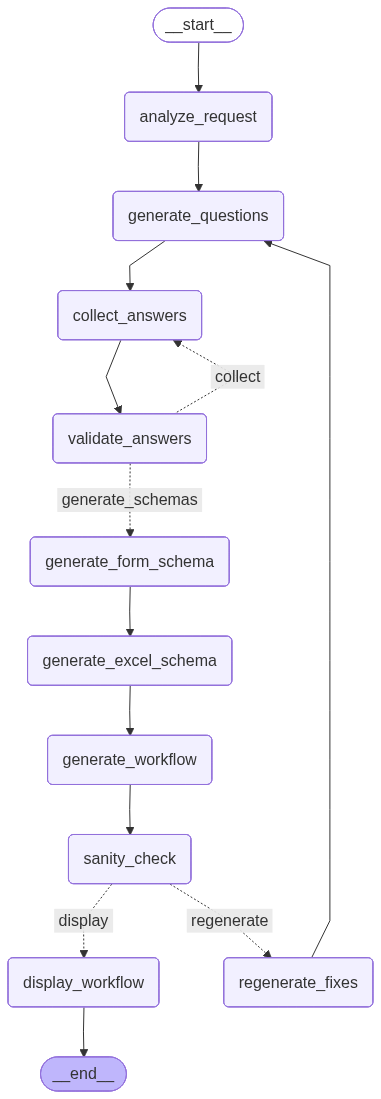

In [24]:
app = build_workflow_graph()
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
if __name__ == "__main__":
    print("="*80)
    print("🎓 MICROSOFT 365 WORKFLOW GENERATOR")
    print("="*80)
    print("\nGenerate Power Automate workflows using Microsoft 365 tools.")
    print("\n📋 REQUIRED FORMAT:")
    print("-"*80)
    print("""
Line 1: Workflow Title
Line 2: Chain of Process (use "to": A to B to C)
Line 3+: Additional Requirements

PLATFORMS (automatic):
• Microsoft Forms - End user input
• Excel (SharePoint) - Activity tracking
• Microsoft Teams Approvals - Approval actions
• Outlook - Email notifications
    """)
    
    print("\n" + "="*80)
    print("📝 EXAMPLES:")
    print("-"*80)
    print("""
Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student will provide mentor, class teacher, and director emails.
Director notified on any rejection.

────────────────────────────────

Industrial Visit Request

Student to Faculty Coordinator to Department Head

Student provides all approver details.
Minimum 5 days notice required.
    """)
    
    print("="*80)
    # user_input = input("\n📝 Enter workflow request:\n\n").strip()
    
    # if not user_input:
    #     lines = []
    #     print("(Enter description. Empty line to finish)")
    #     while True:
    #         line = input()
    #         if line.strip() == "":
    #             break
    #         lines.append(line)
    #     user_input = '\n'.join(lines)
    
    # if not user_input:
    user_input = """Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student will provide mentor, class teacher, and director emails.
Director notified on rejection."""
    
    print("\n" + "="*80)
    print("🤖 Analyzing workflow...")
    print("="*80)
    
    # Initialize state
    initial_state = {
        "user_request": user_input,
        "workflow_analysis": {},
        "approval_chain": [],
        "questions": {},
        "answers": {},
        "validation": {},
        "workflow": {},
        "form_schema": {},
        "excel_schema": {},
        "custom_rules": [],
        "sanity_check": {},
        "sanity_issues": [],
        "regeneration_count": 0,
        "iteration_count": 0,
        "refinement_needed": False,
        "conversation_history": []
    }
    
    # Build and run
    app = build_workflow_graph()
    
    print("\n🚀 Generating components...\n")
    
    try:
        final_state = app.invoke(initial_state)
        
        print("\n" + "="*80)
        print("✅ GENERATION COMPLETE")
        print("="*80)
        
        print("\n📋 DEPLOYMENT STEPS:")
        print("1. Export components (choose option above)")
        print("2. Import to Microsoft 365 services")
        print("3. Test workflow")
        print("4. Deploy to users")
        
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*80)

🎓 MICROSOFT 365 WORKFLOW GENERATOR

Generate Power Automate workflows using Microsoft 365 tools.

📋 REQUIRED FORMAT:
--------------------------------------------------------------------------------

Line 1: Workflow Title
Line 2: Chain of Process (use "to": A to B to C)
Line 3+: Additional Requirements

PLATFORMS (automatic):
• Microsoft Forms - End user input
• Excel (SharePoint) - Activity tracking
• Microsoft Teams Approvals - Approval actions
• Outlook - Email notifications
    

📝 EXAMPLES:
--------------------------------------------------------------------------------

Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student will provide mentor, class teacher, and director emails.
Director notified on any rejection.

────────────────────────────────

Industrial Visit Request

Student to Faculty Coordinator to Department Head

Student provides all approver details.
Minimum 5 days notice required.
    

🤖 Analyzing workflow...

🚀 Generating components...


🔍 

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_8172\1773670454.py", line 92, in <module>
    final_state = app.invoke(initial_state)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\langgraph\pregel\main.py", line 3068, in invoke
    for chunk in self.stream(
                 ^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\langgraph\pregel\main.py", line 2671, in stream
    raise GraphRecursionError(msg)
langgraph.errors.GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT
